- hacim tahminleme
    - klasik model
        - ürün bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler - product economy
        - müşteri bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler - customer economy
        - total geçmiş - indicates whole economy
        - ürün bazlı son 1,2,3,5,7,10 sipariş toplamı/ortalaması
        - diğer featurelar
                - ek veri
                    - enflasyon
                    - döviz
                    - üfe
                    - holiday dataset
                - sipariş satır sayısı
                - order day/week/month
                - sipariş verme sıklığı
                - ürün bazlı sipariş verme sıklığı
                - day diff between last order
    - past data based model
        - convert sales to daily basis
        - geçmiş 10/20/30/40/50/60/90 gün verisi
    - rnn
    - lstm
    - ek veriler:
        dolar kuru
        enflasyon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
order_df = pd.read_csv('datathon_order.csv', parse_dates=['Sipariş Tarihi'], nrows=10000)

In [3]:
order_df.columns = ['order_num', 'order_item', 'order_type', 'material_num', 'order_amount', 
                    'palette_std', 'customer_num', 'order_date', 'operation_type']

In [4]:
def convert_string_to_date(str_date):
    
    str_date = str(str_date)
    str_date = str_date.replace('/','')
    str_date = str_date.replace('.','')
    
    len_date = len(str_date)
    
    if len_date>7:
        return pd.Timestamp(int(str_date[4:]), int(str_date[2:4]), int(str_date[:2]))   
    elif len_date==7:
        return pd.Timestamp(int(str_date[3:]), int(str_date[1:3]), int(str_date[:1]))   
    elif len_date==6:
        return pd.Timestamp(int(str_date[2:]), int(str_date[1:2]), int(str_date[:1]))   

In [5]:
order_df['order_item'] = order_df['order_item'].fillna(0)

In [6]:
order_df.head()

,order_num,order_item,order_type,material_num,order_amount,palette_std,customer_num,order_date,operation_type
0,72616887,1.0,20.0,61001960,60,228.0,C-10008,2020-01-02,O1
1,72616888,1.0,20.0,61000066,25,96.0,C-10185,2020-01-02,O1
2,72616888,2.0,20.0,61001960,50,228.0,C-10185,2020-01-02,O1
3,72616889,1.0,20.0,61000066,40,96.0,C-10188,2020-01-02,O1
4,72616889,2.0,20.0,61001960,20,228.0,C-10188,2020-01-02,O1


In [7]:
# from analysis we saw that customer number 'C-10170' is replaced with 'C-10277', so we replace all the values
order_df.replace('C-10170', 'C-10277', inplace=True)

In [8]:
order_df.isna().sum()

order_num         0
order_item        0
order_type        0
material_num      0
order_amount      0
palette_std       0
customer_num      0
order_date        0
operation_type    0
dtype: int64

In [9]:
for col in order_df.columns:
    print(f'# of unique values in {col} : {order_df[col].nunique()}')

# of unique values in order_num : 1286
# of unique values in order_item : 76
# of unique values in order_type : 2
# of unique values in material_num : 225
# of unique values in order_amount : 281
# of unique values in palette_std : 62
# of unique values in customer_num : 200
# of unique values in order_date : 11
# of unique values in operation_type : 1


In [10]:
order_df.describe()

,order_num,order_item,order_type,order_amount,palette_std
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,7.261776e+07,13.818900,19.923000,26.237600,120.669500
std,4.495415e+02,13.953887,0.874155,103.833966,74.917043
min,7.261689e+07,1.000000,10.000000,1.000000,8.000000
25%,7.261737e+07,3.000000,20.000000,1.000000,63.000000
50%,7.261778e+07,9.000000,20.000000,5.000000,96.000000
75%,7.261814e+07,20.000000,20.000000,19.000000,185.000000
max,7.261850e+07,76.000000,20.000000,3825.000000,650.000000


In [11]:
raw_df = order_df.copy()

In [12]:
# grouping data by order_date, same products may be placed with different orders in same day
order_df = order_df.groupby(['order_date', 'material_num', 'customer_num']).agg(
                                           {'order_item':'max', 'order_type':'max', 
                                            'order_amount':'sum', 'palette_std':'max',
                                            'operation_type':'max', 'order_num':'count'}).reset_index()

In [13]:
order_df['order_weekday'] =  pd.to_datetime(order_df['order_date']).dt.weekday
order_df['order_month'] = pd.to_datetime(order_df['order_date']).dt.month
order_df['order_day'] = pd.to_datetime(order_df['order_date']).dt.day
order_df['order_week'] = pd.to_datetime(order_df['order_date']).dt.week

In [14]:
order_df['order_num'] = order_df['order_num'].astype('int16')
order_df['order_item'] = order_df['order_item'].astype('int16')
order_df['material_num'] = order_df['material_num'].astype('str')
order_df['order_amount'] = order_df['order_amount'].astype('int32')

order_df['order_type'] = order_df['order_type'].astype('category')
order_df['palette_std'] = order_df['palette_std'].astype('category')
order_df['customer_num'] = order_df['customer_num'].astype('category')
order_df['operation_type'] = order_df['operation_type'].astype('category')

In [15]:
order_df.columns

Index(['order_date', 'material_num', 'customer_num', 'order_item',
       'order_type', 'order_amount', 'palette_std', 'operation_type',
       'order_num', 'order_weekday', 'order_month', 'order_day', 'order_week'],
      dtype='object')

In [16]:
order_df.groupby(['material_num'])['order_amount'].sum().nlargest(10)

material_num
PL04751A    20787
TR00186C    15344
TR02285A    14904
61001960    14848
PL06924B    13617
TR01575A    11644
61003848     5946
TR02287A     5063
TR02288A     4950
61000066     4085
Name: order_amount, dtype: int32

In [17]:
order_df.groupby(['material_num'])['order_amount'].sum().nsmallest(10)

material_num
TR02218A     1
61000267     2
FTP00017     2
TR02341A     4
61000404     7
CN06988A     7
TR02342A     7
TR02340A    11
TR01182A    12
CN07279A    15
Name: order_amount, dtype: int32

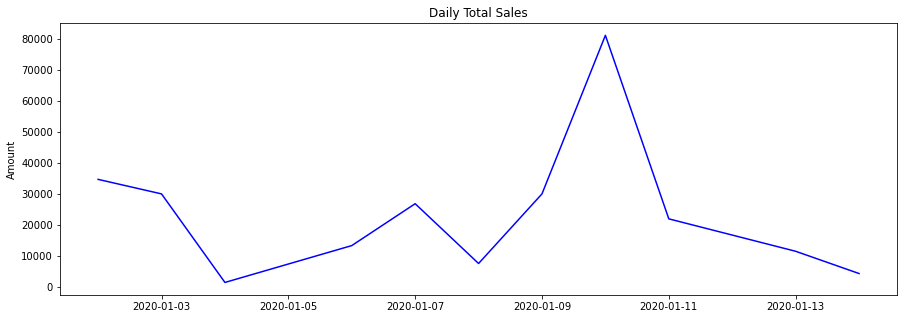

In [18]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_summary.index, order_summary.values, 'b')
plt.title('Daily Total Sales')
plt.ylabel('Amount')
plt.show();

when we analyze the daily total sales, dataset looks like stationary whihch does not have any trend or seasonality

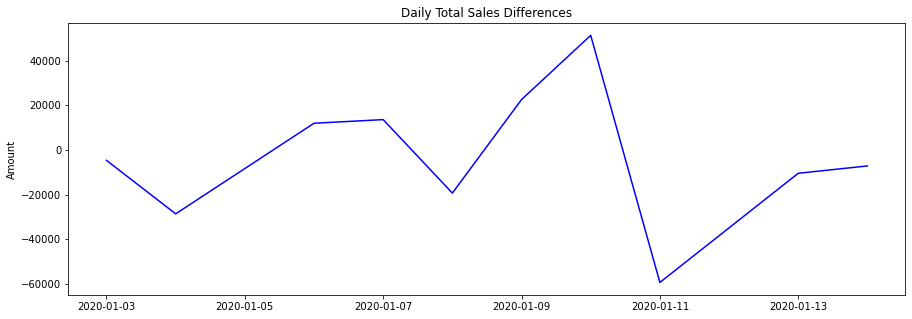

In [19]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
daily_diff = order_summary-order_summary.shift(1)
plt.figure(figsize=(15,5))
plt.plot(daily_diff.index, daily_diff.values, 'b')
plt.title('Daily Total Sales Differences')
plt.ylabel('Amount')
plt.show();

In [20]:
from statsmodels.tsa.stattools import adfuller
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
adf_result = adfuller(order_summary)
print(adf_result)

(-2.3390956806753107, 0.15966858922688043, 3, 7, {'1%': -4.9386902332361515, '5%': -3.477582857142857, '10%': -2.8438679591836733}, 164.053908763949)


p value is less than 0.05 we reject the H0 hypothesis, meaning our data is stationary

ValueError: operands could not be broadcast together with shapes (29,) (9,) (29,) 

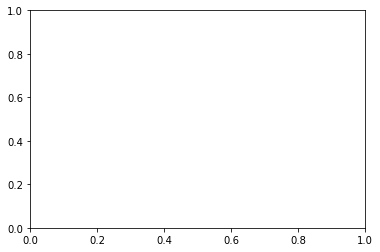

In [21]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(order_summary, lags=30)

ValueError: operands could not be broadcast together with shapes (3,) (11,) 

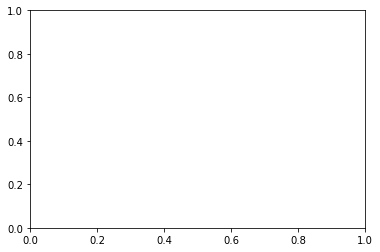

In [22]:
order_summary = order_df.groupby(['order_week'])['order_amount'].sum()
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(order_summary, lags=10)

In [ ]:
for material in order_df.groupby(['material_num'])['order_amount'].sum().nlargest(10).index:
    
    mat_orders = order_df[order_df['material_num']==material].groupby(['order_date'])['order_amount'].sum()
    
    plot_acf(mat_orders, lags=30)

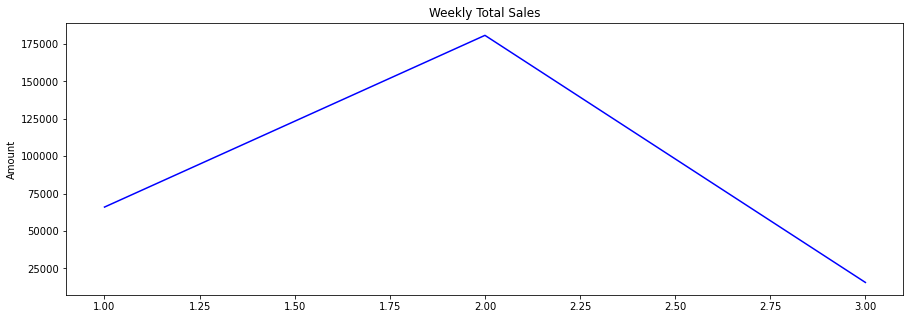

In [23]:
order_summary = order_df.groupby(order_df['order_date'].dt.week)['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_summary.index, order_summary.values, 'b')
plt.title('Weekly Total Sales')
plt.ylabel('Amount')
plt.show();

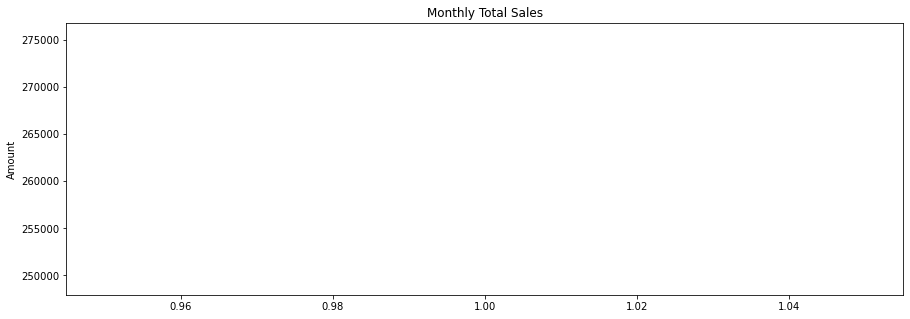

In [24]:
order_summary = order_df.groupby(order_df['order_date'].dt.month)['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_summary.index, order_summary.values, 'b')
plt.title('Monthly Total Sales')
plt.ylabel('Amount')
plt.show();

when we look at the weekly and monthly sales there is an increase in 2-4 months

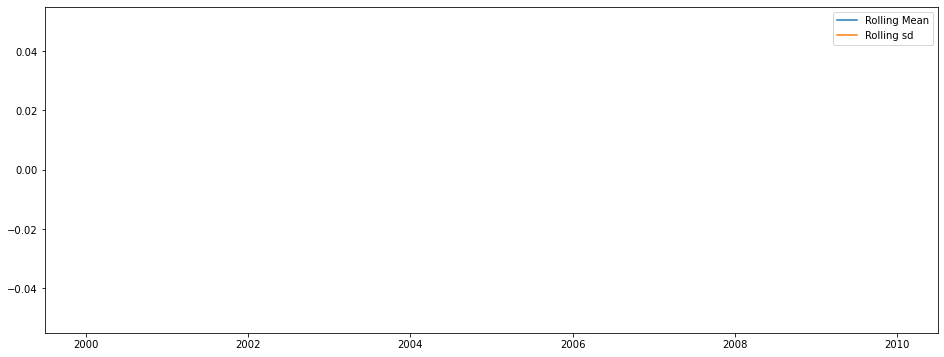

In [25]:
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
plt.figure(figsize=(16,6))
plt.plot(order_summary.rolling(window=30,center=False).mean(),label='Rolling Mean');
plt.plot(order_summary.rolling(window=30,center=False).std(),label='Rolling sd');
plt.legend();

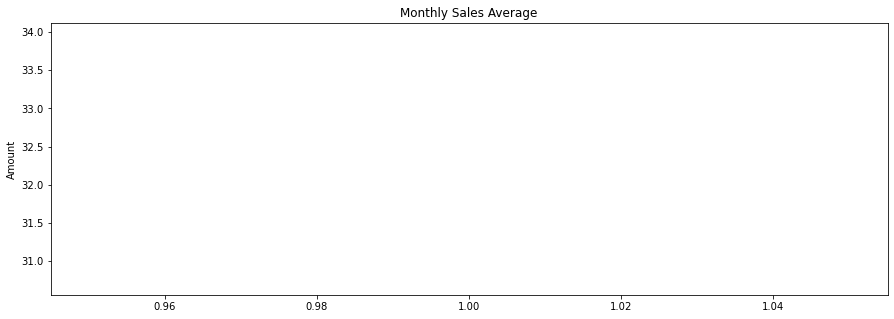

In [26]:
order_avgs = order_df.groupby(['order_month']).agg(order_count = ('order_amount', 'count'),
                                                   order_sum = ('order_amount', 'sum')).reset_index()

order_avgs['avg_monthly_order_amounts'] = order_avgs['order_sum']/order_avgs['order_count']

order_summary = order_df.groupby(order_df['order_date'].dt.week)['order_amount'].sum()
plt.figure(figsize=(15,5))
plt.plot(order_avgs['order_month'], order_avgs['avg_monthly_order_amounts'], 'b')
plt.title('Monthly Sales Average')
plt.ylabel('Amount')
plt.show();

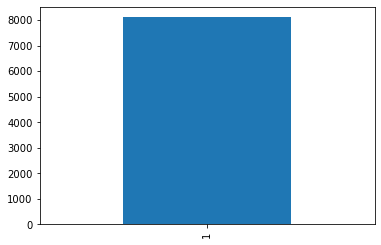

In [27]:
order_df['order_month'].value_counts().sort_index().plot(kind='bar')

In [28]:
order_df.groupby(['order_type'])['order_amount'].sum()

order_type
10.0     35341
20.0    227035
Name: order_amount, dtype: int32

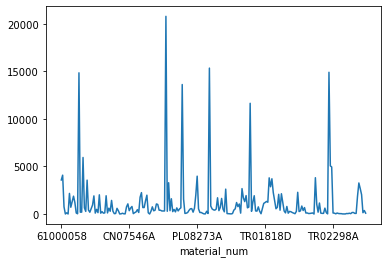

In [29]:
order_df.groupby(['material_num'])['order_amount'].sum().plot()

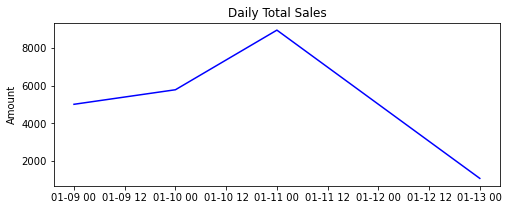

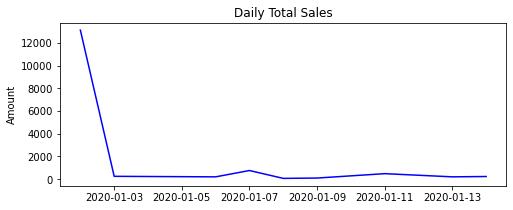

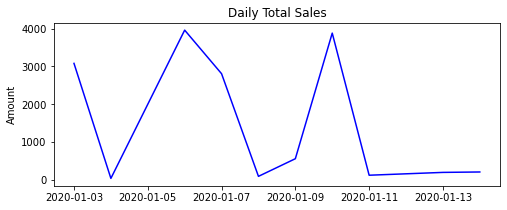

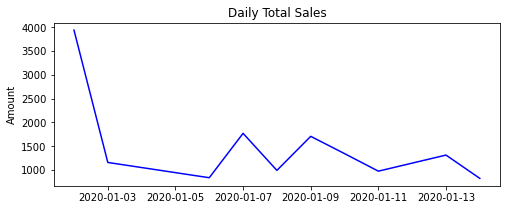

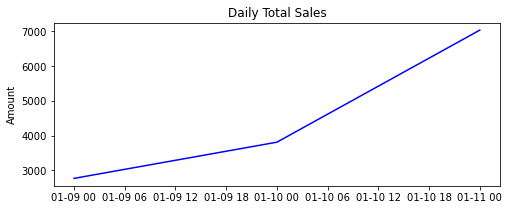

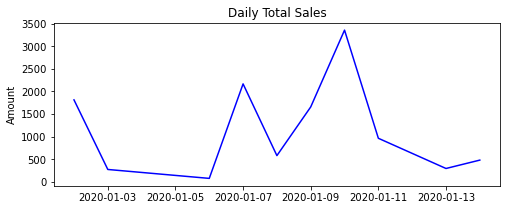

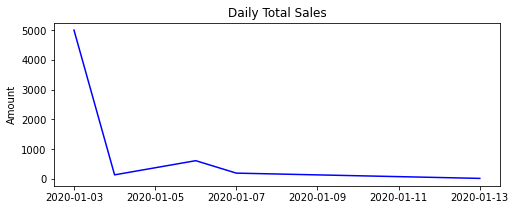

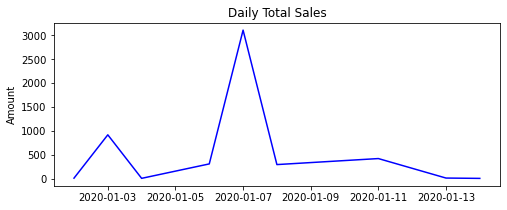

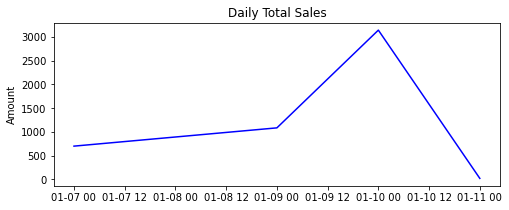

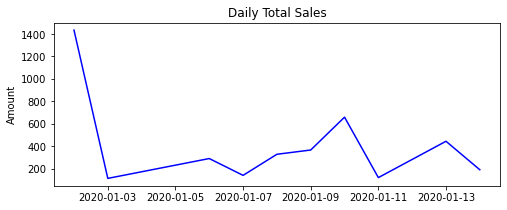

In [30]:
# daily sales for top 10 materials

for material in order_df.groupby(['material_num'])['order_amount'].sum().nlargest(10).index:
    
    mat_orders = order_df[order_df['material_num']==material].groupby(['order_date'])['order_amount'].sum()
    
    plt.figure(figsize=(8,3))
    plt.plot(mat_orders.index, mat_orders.values, 'b')
    plt.title('Daily Total Sales')
    plt.ylabel('Amount')
    plt.show();

our data looks stationary, so it is not possible to predict the future sales by only past data. There is a need to create some complex features to increase model performance

In [31]:
order_df.head(3)

,order_date,material_num,customer_num,order_item,order_type,order_amount,palette_std,operation_type,order_num,order_weekday,order_month,order_day,order_week
0,2020-01-02,61000058,C-10001,17,20.0,2,45.0,O1,1,3,1,2,1
1,2020-01-02,61000058,C-10003,37,20.0,7,45.0,O1,1,3,1,2,1
2,2020-01-02,61000058,C-10005,1,10.0,1395,45.0,O1,2,3,1,2,1


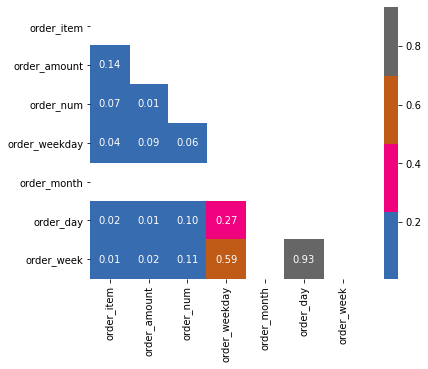

In [32]:
matrix = order_df.corr().abs()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
plt.figure(figsize=(8, 5))
sns.heatmap(matrix, mask=mask, center=0, annot=True, fmt='.2f', square=True, cmap='Accent')

plt.show();

In [33]:
order_df.dtypes

order_date        datetime64[ns]
material_num              object
customer_num            category
order_item                 int16
order_type              category
order_amount               int32
palette_std             category
operation_type          category
order_num                  int16
order_weekday              int64
order_month                int64
order_day                  int64
order_week                 int64
dtype: object

# classical methods

### feature engineering

In [34]:
order_df.head()

,order_date,material_num,customer_num,order_item,order_type,order_amount,palette_std,operation_type,order_num,order_weekday,order_month,order_day,order_week
0,2020-01-02,61000058,C-10001,17,20.0,2,45.0,O1,1,3,1,2,1
1,2020-01-02,61000058,C-10003,37,20.0,7,45.0,O1,1,3,1,2,1
2,2020-01-02,61000058,C-10005,1,10.0,1395,45.0,O1,2,3,1,2,1
3,2020-01-02,61000058,C-10006,28,20.0,9,45.0,O1,1,3,1,2,1
4,2020-01-02,61000058,C-10013,19,20.0,7,45.0,O1,1,3,1,2,1


In [35]:
order_df.shape

(8113, 13)

### ürün ve müşteri bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler

In [111]:
daily_order_amounts = order_df[['customer_num', 'material_num','order_date', 'order_amount']].copy()
daily_order_amounts.head()

,customer_num,material_num,order_date,order_amount
0,C-10001,61000058,2020-01-02,2
1,C-10003,61000058,2020-01-02,7
2,C-10005,61000058,2020-01-02,1395
3,C-10006,61000058,2020-01-02,9
4,C-10013,61000058,2020-01-02,7


In [ ]:
daily_order_amounts = order_df[['customer_num', 'material_num','order_date', 'order_amount']].copy()

results_by_mat_cust = pd.DataFrame()

for cust_key in daily_order_amounts['customer_num'].unique():
    
    cust_tmp_df = daily_order_amounts[daily_order_amounts['customer_num']==cust_key].drop('customer_num', axis=1)
    
    for material in cust_tmp_df['material_num'].unique():
        
        tmp_df = cust_tmp_df[cust_tmp_df['material_num']==material].drop('material_num', axis=1).set_index('order_date')
        
        current_day_orders = np.atleast_2d(tmp_df['order_amount'].values).T
        
        rolling_df = tmp_df.copy()
        rolling_df['customer_num'] = cust_key
        rolling_df['material_num'] = material

        for day_num in [1, 2, 3, 5, 7, 14, 30]:

            col_name = 'last_' + str(day_num) + '_day_sum'

            rolling_df[col_name] = tmp_df.rolling(str(day_num)+'d').sum().values - current_day_orders
        
        results_by_mat_cust = pd.concat([results_by_mat_cust, rolling_df.reset_index()], axis=0).reset_index(drop=True)

In [ ]:
results_by_mat_cust

### ürün bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler - product economy

In [ ]:
daily_order_amounts = order_df.groupby(['material_num','order_date'])['order_amount'].sum().reset_index()

results_by_mat = pd.DataFrame()

    
for material in daily_order_amounts['material_num'].unique():

    tmp_df = daily_order_amounts[daily_order_amounts['material_num']==material].drop('material_num', axis=1).set_index('order_date')

    current_day_orders = np.atleast_2d(tmp_df['order_amount'].values).T

    rolling_df = tmp_df.copy()
    rolling_df['material_num'] = material

    for day_num in [1, 2, 3, 5, 7, 14, 30]:

        col_name = 'last_' + str(day_num) + '_day_sum'

        rolling_df[col_name] = tmp_df.rolling(str(day_num)+'d').sum().values - current_day_orders

    results_by_mat = pd.concat([results_by_mat, rolling_df.reset_index()], axis=0).reset_index(drop=True)

In [ ]:
results_by_mat

### müşteri bazlı geçmiş 1,2,3,5,7,14,30 günlük toplam/ortalama siparişler - customer economy

In [ ]:
daily_order_amounts = order_df.groupby(['customer_num', 'material_num','order_date'])['order_amount'].sum().reset_index()

results_by_cust = pd.DataFrame()

for cust_key in daily_order_amounts['customer_num'].unique():
    
    tmp_df = daily_order_amounts[daily_order_amounts['customer_num']==cust_key].drop('customer_num', axis=1).set_index('order_date')
         
    current_day_orders = np.atleast_2d(tmp_df['order_amount'].values).T

    rolling_df = tmp_df.copy()
    rolling_df['customer_num'] = cust_key

    for day_num in [1, 2, 3, 5, 7, 14, 30]:

        col_name = 'last_' + str(day_num) + '_day_sum'

        rolling_df[col_name] = tmp_df.rolling(str(day_num)+'d').sum().values - current_day_orders

    results_by_cust = pd.concat([results_by_cust, rolling_df.reset_index()], axis=0).reset_index(drop=True)

In [ ]:
results_by_cust

### toplam geçmiş 1,2,3,5,7,14,30 günlük toplam siparişler - whole economy

In [ ]:
daily_order_amounts = order_df.groupby(['customer_num', 'material_num','order_date'])['order_amount'].sum().reset_index()

results_by_cust = pd.DataFrame()

for cust_key in daily_order_amounts['customer_num'].unique():
    
    tmp_df = daily_order_amounts[daily_order_amounts['customer_num']==cust_key].drop('customer_num', axis=1).set_index('order_date')
         
    current_day_orders = np.atleast_2d(tmp_df['order_amount'].values).T

    rolling_df = tmp_df.copy()
    rolling_df['customer_num'] = cust_key

    for day_num in [1, 2, 3, 5, 7, 14, 30]:

        col_name = 'last_' + str(day_num) + '_day_sum'

        rolling_df[col_name] = tmp_df.rolling(str(day_num)+'d').sum().values - current_day_orders

    results_by_cust = pd.concat([results_by_cust, rolling_df.reset_index()], axis=0).reset_index(drop=True)

In [ ]:
stopp

In [ ]:
trials 

- toplamlar mı ortalamalar mı?

In [ ]:
- total geçmiş - indicates whole economy

In [ ]:
- ürün bazlı son 1,2,3,5,7,10 sipariş toplamı/ortalaması

In [ ]:
- diğer featurelar
        - ek veri
            - enflasyon
            - döviz
            - üfe
            - holiday dataset
        - sipariş satır sayısı
        - order day/week/month
        - sipariş verme sıklığı
        - ürün bazlı sipariş verme sıklığı
        - day diff between last order

In [ ]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [ ]:
ols regression

# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

#### day difference between last order

In [ ]:
material_order_dates = df.groupby(['customer_num','order_num', 'material_num'])['order_date'].min().reset_index()
material_order_dates['shifted_date'] = material_order_dates.groupby(['customer_num','order_num', 'material_num'])['order_date'].diff()

#### last 1,2,3,5,7,10 orders

In [ ]:
order_amounts = df.groupby(['customer_num', 'material_num','order_num'])['order_amount'].sum().reset_index()
for period in [1,2,3,5,7,10]:
    col_name = 'last_' + str(period) + '_period_sum'
    order_amounts['rolling_sum'] = order_amounts.groupby(['customer_num', 'material_num'])['order_amount'] \
    .rolling(period, min_periods=period).sum().values
    
    order_amounts[col_name] = order_amounts.groupby(['customer_num', 'material_num'])['rolling_sum'].shift(1)

In [ ]:
order_amounts.isna().sum()/order_amounts.shape[0]

In [ ]:
df = pd.merge(df, order_amounts.drop(['order_amount', 'rolling_sum'], axis=1), on=['customer_num', 'material_num', 'order_num'])

### order_item numbers in an order

In [ ]:
item_counts = df.groupby(['order_num'])['order_item'].count().reset_index()
item_counts.columns = ['order_num', 'num_order_item']
df = pd.merge(df, item_counts, on=['order_num'], how='left')

#### last period averages

In [ ]:
df['last_2_period_avg'] = df['last_2_period_sum']/2
df['last_3_period_avg'] = df['last_3_period_sum']/3
df['last_5_period_avg'] = df['last_5_period_sum']/5
df['last_7_period_avg'] = df['last_7_period_sum']/7
df['last_10_period_avg'] = df['last_10_period_sum']/10

In [ ]:
weekly_resample = df.rolling('7D')
aggregated_df = weekly_resample.agg(['min', 'mean', 'max', 'std'])
aggregated_df.columns = ['_'.join(col).strip() + '_week' for col in 
                         aggregated_df.columns.values]

In [ ]:
order_df.sort_values(by=['order_date','order_num'], inplace=True)

In [ ]:
for i in range(len(order_df)):
    if order_df.order_num[i] > order_df.order_num[i+1]:
        print(i)

In [ ]:
order_df.head()

In [ ]:
from statsmodels.tsa.stattools import adfuller
order_summary = order_df.groupby(['order_date'])['order_amount'].sum()
adf_result = adfuller(order_summary)
print(adf_result)

### mean encoding for customer and product ??? or did we include that feature

In [ ]:
item_target_enc_na = .3343 # default na replacement
# Expanding Mean
cumsum = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id')['target'].cumcount()

all_data['item_target_enc'] = cumsum/cumcnt
all_data['item_target_enc'].fillna(item_target_enc_na,inplace=True)
corr = np.corrcoef(all_data['target'].values, all_data['item_target_enc'])[0][1]
print(corr)

In [ ]:
sadece difference üzerinden featurelar bul

    - past data based model
        - convert sales to daily basis
        - geçmiş 10/20/30/40/50/60/90 gün verisi

## modelling

### lightgbm

In [ ]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

In [ ]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

In [ ]:
cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

preds = lgb_model.predict(X_test).clip(0,20)

In [94]:
# creating dataframe for all customers, all materials and all dates

unq_materials = pd.DataFrame(order_df['material_num'].unique(), columns=['material_num'])
unq_materials['key'] = 1
unq_customers = pd.DataFrame(order_df['customer_num'].unique(), columns=['customer_num'])
unq_customers['key'] = 1
dates = pd.DataFrame(pd.date_range(start=raw_df['order_date'].min(), end=raw_df['order_date'].max()), columns=['order_date'])
dates['key'] = 1
all_data = pd.merge(dates, unq_customers, on=['key'])
all_data = pd.merge(all_data, unq_materials, on=['key']).drop('key', axis=1)

In [95]:
all_data = pd.merge(all_data, daily_order_amounts, on=['customer_num', 'material_num', 'order_date'], how='left')

In [96]:
all_data.isna().sum()/all_data.shape[0]*100

order_date       0.000000
customer_num     0.000000
material_num     0.000000
order_amount    98.613162
dtype: float64

In [102]:
all_data['order_amount'] = all_data['order_amount'].fillna(0.0)